In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/My Drive/data/tiny-imagenet-200.zip"

In [ ]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [ ]:
### Constants ###
DATA_DIR = "/content/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

In [ ]:
def load_dataset_small(num_images_per_class_train=100, num_images_test=5000):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        #for img_name_i in c_imgs[0:num_images_per_class_train]:
        for img_name_i in c_imgs:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    #for img_name_i in test_imgs[0:num_images_test]:
    for img_name_i in test_imgs:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [ ]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 100000
Number of test examples = 10000
X_train shape: (100000, 64, 64, 3)


In [ ]:
del X_train_orig, X_test_orig

In [ ]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

### Fresh Working Code 

In [ ]:
block_size = 8

In [ ]:
%%time
input_S = X_train[0:32]

batch_size, row, col, channel = input_S.shape
block_in_one_axis = row // block_size
total_block = block_in_one_axis**2

print(input_S.shape)
blocks = tf.image.extract_patches(input_S,sizes=[1,block_size,block_size,1],strides=[1,block_size,block_size,1],rates=[1, 1, 1, 1],padding='VALID')
print(blocks.shape)
blocks = tf.reshape(blocks,[batch_size, total_block, block_size, block_size, channel])
print("after creating blocks")
print(blocks.shape)

input_K = np.zeros(shape=(batch_size, total_block))

for i in range(batch_size):
    input_K[i] = random.sample(range(0, total_block), total_block)

i1 = tf.expand_dims(tf.range(batch_size), axis = 1)
i1 = tf.tile(i1, [1, total_block])
indices = tf.stack([i1,input_K ], axis=-1)

scattered = tf.scatter_nd(indices, blocks, blocks.shape)
print("after scattering")
print(scattered.shape)


scattered_blocks = tf.unstack(scattered, axis =1)
scattered_tensor_row_wise = [tf.keras.layers.concatenate(scattered_blocks[x:x+block_in_one_axis], axis = -2) for x in tf.range(0,total_block,block_in_one_axis)]
scattered_tensor = tf.keras.layers.concatenate(scattered_tensor_row_wise, axis = 1)
print(scattered_tensor.shape)



(32, 64, 64, 3)
(32, 2, 2, 3072)
after creating blocks
(32, 4, 32, 32, 3)
after scattering
(32, 4, 32, 32, 3)
(32, 64, 64, 3)
CPU times: user 10.4 ms, sys: 0 ns, total: 10.4 ms
Wall time: 8.89 ms


In [ ]:
%%time
blocks = tf.image.extract_patches(scattered_tensor,sizes=[1,block_size,block_size,1],strides=[1,block_size,block_size,1],rates=[1, 1, 1, 1],padding='VALID')
blocks = tf.reshape(blocks,[batch_size,total_block,block_size,block_size,channel])
print(blocks.shape)

unscattered = tf.gather_nd(blocks,indices)

unscattered_blocks = tf.unstack(unscattered, axis =1)
unscattered_tensor_row_wise = [tf.keras.layers.concatenate(unscattered_blocks[x:x+block_in_one_axis], axis = -2) for x in tf.range(0,total_block,block_in_one_axis)]
unscattered_tensor = tf.keras.layers.concatenate(unscattered_tensor_row_wise, axis = 1)
print(unscattered_tensor.shape)

(32, 4, 32, 32, 3)
(32, 64, 64, 3)
CPU times: user 7.34 ms, sys: 0 ns, total: 7.34 ms
Wall time: 9.18 ms


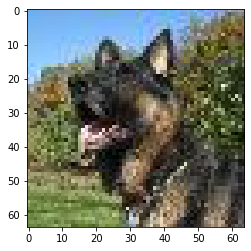

In [ ]:
plt.imshow(input_S[2])

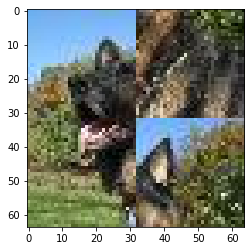

In [ ]:
plt.imshow(scattered_tensor[2])

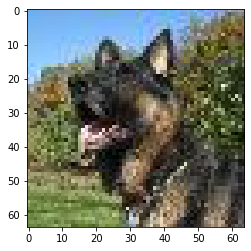

In [ ]:
plt.imshow(unscattered_tensor[2])